In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as NF
import torchvision.transforms.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from torchvision.utils import make_grid
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/home/rmalone/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2023-06-29 12:03:20.822143: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 12:03:21.095625: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-29 12:03:21.097377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebu

In [2]:
# Set device to GPU if available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cuda:0


In [3]:
 # Create custom dataset object with images seperated in class specific folders

class CustomDataset(Dataset):
    def __init__(self, class_names, img_dir, transform=None, target_transform=None):
        
        class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
        img_paths = []
        labels = []
        
        for folder in os.listdir(img_dir):
            label = class_names_label[folder]
            for file in os.listdir(os.path.join(img_dir, folder)):
                img_path = os.path.join(os.path.join(img_dir, folder), file)
                img_paths.append(img_path)
                labels.append(int(label))
                
        self.img_labels = pd.DataFrame(np.column_stack([img_paths, labels]))
        self.img_paths = img_paths
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        
        return len(self.img_labels)
        
        
    def __getitem__(self, idx):
        
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        image = F.convert_image_dtype(image, dtype=torch.float)
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return (image, label)

In [4]:
class_names = ['berry', 'bird', 'dog', 'flower', 'other']
batch_size = 32

# Add transforms to images to protect against overfitting
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.33), interpolation=2)
])

train_set = CustomDataset(class_names, r'Linnaeus 5 32X32\train', transform=transform)
test_set = CustomDataset(class_names, r'Linnaeus 5 32X32\test')

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True)

In [15]:
print('Training set has {} instances'.format(len(train_set)))
print('Test set has {} instances'.format(len(test_set)))

print(test_set[0][0].shape)

Training set has 6000 instances
Test set has 2000 instances
torch.Size([3, 32, 32])


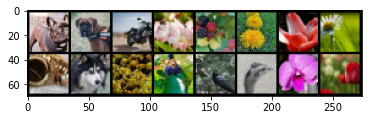

In [6]:
def show_img(image):
    np_image = image.numpy()
    plt.imshow(np.transpose(np_image, (1, 2, 0)))
    
dataiter = iter(train_loader)
images, labels = dataiter.next()

image_grid = torchvision.utils.make_grid(images)
show_img(image_grid)

In [7]:
#model = torchvision.models.googlenet(pretrained=True)
#model.to(device)

# PyTorch models inherit from torch.nn.Module
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 8 * 8, 5)

    def forward(self, x):
        x = NF.relu(self.conv1(x))
        x = self.pool1(x)
        x = NF.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 8 * 8)
        x = self.fc1(x)
        return x
    
model = ConvModel()
model.to(device)

ConvModel(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=5, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train_one_epoch(epoch_idx, tb_writer):
    running_loss = 0
    last_loss = 0
    
    scaler = torch.cuda.amp.GradScaler()
    
    for i, data in enumerate(train_loader):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
        scaler.scale(loss).backward()
        
        scaler.step(optimizer)
        
        scaler.update()
        
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_idx * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
            
    return last_loss

In [13]:
def check_accuracy(loader, model):
    
    if loader == train_loader:
        print("Training set accuracy: ")
    else:
        print("Test set accuracy: ")
        
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = (float(num_correct) / num_samples) * 100.0
        print("Got %d / %d correct (%.2f)" % (num_correct, num_samples, acc))
        
        return acc

In [14]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.eval()

    running_vloss = 0.0
    for i, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = criterion(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    '''# Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()
    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    '''

    epoch_number += 1
    
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

EPOCH 1:
  batch 100 loss: 1.0260861390829086
  batch 200 loss: 1.0359278923273088
  batch 300 loss: 1.0329345327615738
LOSS train 1.0329345327615738 valid 1.0403536558151245
EPOCH 2:
  batch 100 loss: 0.9768433517217636
  batch 200 loss: 1.0260176706314086
  batch 300 loss: 1.0159680509567262
LOSS train 1.0159680509567262 valid 1.0490334033966064
EPOCH 3:
  batch 100 loss: 0.9596948504447937
  batch 200 loss: 1.020076470375061
  batch 300 loss: 0.976259149312973
LOSS train 0.976259149312973 valid 1.0651031732559204
EPOCH 4:
  batch 100 loss: 0.9726285117864609
  batch 200 loss: 0.988411681652069
  batch 300 loss: 0.9894416743516922
LOSS train 0.9894416743516922 valid 1.0313804149627686
EPOCH 5:
  batch 100 loss: 0.9526317673921585
  batch 200 loss: 0.9614274543523789
  batch 300 loss: 0.9534429389238358
LOSS train 0.9534429389238358 valid 1.0238933563232422
EPOCH 6:
  batch 100 loss: 0.9421322083473206
  batch 200 loss: 0.9069015002250671
  batch 300 loss: 0.951789693236351
LOSS train

  batch 100 loss: 0.5610036459565163
  batch 200 loss: 0.5454350244998932
  batch 300 loss: 0.5501759919524193
LOSS train 0.5501759919524193 valid 1.1723965406417847
EPOCH 49:
  batch 100 loss: 0.5248183281719685
  batch 200 loss: 0.5823628738522529
  batch 300 loss: 0.5900549231469632
LOSS train 0.5900549231469632 valid 1.1928266286849976
EPOCH 50:
  batch 100 loss: 0.537333388030529
  batch 200 loss: 0.5512817719578743
  batch 300 loss: 0.5764819914102555
LOSS train 0.5764819914102555 valid 1.176364541053772
EPOCH 51:
  batch 100 loss: 0.5248064196109772
  batch 200 loss: 0.5525059142708778
  batch 300 loss: 0.5699266511201858
LOSS train 0.5699266511201858 valid 1.2600263357162476
EPOCH 52:
  batch 100 loss: 0.5264028576016426
  batch 200 loss: 0.5099093943834305
  batch 300 loss: 0.5711583150923252
LOSS train 0.5711583150923252 valid 1.2136708498001099
EPOCH 53:
  batch 100 loss: 0.5144652092456817
  batch 200 loss: 0.5333099415898324
  batch 300 loss: 0.5492609006911516
LOSS train 

  batch 300 loss: 0.41459759548306463
LOSS train 0.41459759548306463 valid 1.6383486986160278
EPOCH 95:
  batch 100 loss: 0.3557573539018631
  batch 200 loss: 0.3619399236142635
  batch 300 loss: 0.39606593661010264
LOSS train 0.39606593661010264 valid 1.627310037612915
EPOCH 96:
  batch 100 loss: 0.3322374504804611
  batch 200 loss: 0.38720258928835394
  batch 300 loss: 0.39555876158177855
LOSS train 0.39555876158177855 valid 1.6325663328170776
EPOCH 97:
  batch 100 loss: 0.3385604932159185
  batch 200 loss: 0.3470366097986698
  batch 300 loss: 0.37586511954665186
LOSS train 0.37586511954665186 valid 1.7447084188461304
EPOCH 98:
  batch 100 loss: 0.32337425477802756
  batch 200 loss: 0.37730988427996637
  batch 300 loss: 0.3955094226449728
LOSS train 0.3955094226449728 valid 1.667350172996521
EPOCH 99:
  batch 100 loss: 0.36149229280650613
  batch 200 loss: 0.37354625314474105
  batch 300 loss: 0.3673296047002077
LOSS train 0.3673296047002077 valid 1.6582945585250854
EPOCH 100:
  batc

TypeError: eval() missing 1 required positional argument: 'self'

In [15]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Training set accuracy: 
Got 5250 / 6000 correct (87.50)
Test set accuracy: 
Got 1135 / 2000 correct (56.75)


56.75